In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from astropy.io import fits
import fpf_calculator
import glob, os
import numpy as np
import operator

## SNR function

In [2]:
from vip_hci.var import frame_center, dist
import photutils
import matplotlib.pyplot as plt

def snr_ss(array, 
           xxx_todo_changeme1,
           fwhm,
           out_coor=False, 
           plot=False, 
           verbose=False,
           full_output=False):
    # Leave the order of parameters as it is, the same for both snr functions
    # to be compatible with the snrmap parallel implementation
    """Calculates the SNR (signal to noise ratio) of a single planet in a 
    post-processed (e.g. by LOCI or PCA) frame. Uses the approach described in 
    Mawet et al. 2014 on small sample statistics, where a student t-test (eq. 9)
    can be used to determine S/N (and contrast) in high contrast imaging.
    
    Parameters
    ----------
    array : array_like, 2d
        Post-processed frame where we want to measure SNR.
    source_xy : tuple of floats
        X and Y coordinates of the planet or test speckle.
    fwhm : float
        Size in pixels of the FWHM.
    out_coor: {False, True}, bool optional
        If True returns back the snr value and the y, x input coordinates. In 
        this case it overrides the full_output parameter.
    plot : {False, True}, bool optional
        Plots the frame and the apertures considered for clarity. 
    verbose: {True, False}, bool optional
        Chooses whether to print some output or not. 
    full_output: {False, True}, bool optional
        If True returns back the snr value, the y, x input coordinates, noise 
        and flux.   
    
    Returns
    -------
    snr : float
        Value of the SNR for the given planet or test speckle.
        
    sourcey, sourcex, f_source, fluxes.std(), snr
    
    """
    (source_xy) = xxx_todo_changeme1
    if not array.ndim==2:
        raise TypeError('Input array is not a frame or 2d array')
    if out_coor and full_output:
        raise TypeError('One of the 2 must be False')
    
    sourcex, sourcey = source_xy 
    
    centery, centerx = frame_center(array)
    sep = dist(centery,centerx,sourcey,sourcex)
    
    sens = 'clock' #counterclock
        
    angle = np.arcsin(fwhm/2./sep)*2
    number_apertures = int(np.floor(2*np.pi/angle))
    yy = np.zeros((number_apertures))
    xx = np.zeros((number_apertures))
    cosangle = np.cos(angle)
    sinangle = np.sin(angle)
    xx[0] = sourcex - centerx
    yy[0] = sourcey - centery
    for i in range(number_apertures-1):
        if sens=='clock':
            xx[i+1] = cosangle*xx[i] + sinangle*yy[i] 
            yy[i+1] = cosangle*yy[i] - sinangle*xx[i] 
        elif sens=='counterclock':
            xx[i+1] = cosangle*xx[i] - sinangle*yy[i] 
            yy[i+1] = cosangle*yy[i] + sinangle*xx[i]           
            
    xx[:] += centerx
    yy[:] += centery 
    
    xx = xx[0:-1]
    yy = yy[0:-1]
    xx = np.delete(xx, 1)
    yy = np.delete(yy, 1)
    
    rad = fwhm/2.
    apertures = photutils.CircularAperture((xx, yy), r=rad)  # Coordinates (X,Y)
    fluxes = photutils.aperture_photometry(array, apertures, method='exact')

    fluxes = np.array(fluxes['aperture_sum'])
    f_source = fluxes[0].copy()
    fluxes = fluxes[1:]
    n2 = fluxes.shape[0]
    snr = (f_source - fluxes.mean())/(fluxes.std()*np.sqrt(1+(1/n2)))
    
    if verbose:
        msg1 = 'S/N for the given pixel = {:}'
        msg2 = 'Integrated flux in FWHM test aperture = {:.3f}'
        msg3 = 'Mean of background apertures integrated fluxes = {:.3f}'
        msg4 = 'Std-dev of background apertures integrated fluxes = {:.3f}'
        print(msg1.format(snr))
        print(msg2.format(f_source))
        print(msg3.format(fluxes.mean()))
        print(msg4.format(fluxes.std()))
    
    if plot:
        _, ax = plt.subplots(figsize=(6,6))
        ax.imshow(array, origin='lower', interpolation='nearest', alpha=0.5, cmap='gray')
        for i in range(xx.shape[0]):
            # Circle takes coordinates as (X,Y)
            aper = plt.Circle((xx[i], yy[i]), radius=fwhm/2., color='r', 
                              fill=False, alpha=0.8)                                       
            ax.add_patch(aper)
            cent = plt.Circle((xx[i], yy[i]), radius=0.8, color='r', fill=True,
                              alpha=0.5)
            ax.add_patch(cent)
            aper_source = plt.Circle((sourcex, sourcey), radius=0.7, 
                                     color='b', fill=True, alpha=0.5)                                       
            ax.add_patch(aper_source)
        ax.grid('off')
        plt.show()
    
    if out_coor:
        return sourcey, sourcex, snr
    if full_output:
        return sourcey, sourcex, f_source, fluxes.std(), snr
    else:
        return snr

---------------------------------------------------
        oooooo     oooo ooooo ooooooooo.           
         `888.     .8'  `888' `888   `Y88.         
          `888.   .8'    888   888   .d88'         
           `888. .8'     888   888ooo88P'          
            `888.8'      888   888                 
             `888'       888   888                 
              `8'       o888o o888o                
---------------------------------------------------
     Vortex Image Processing package v0.8.2
---------------------------------------------------


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/vip_hci/pca/svd.py:21: ImportWarning: Cupy not found. Have a GPU? Consider setting up a CUDA environment and installing cupy >= 2.0.0
  warnings.warn(msg, ImportWarning)


In [22]:
from skimage.transform import resize
from scipy.ndimage.interpolation import shift
import cv2 as cv

def calc_SNR(planet_pos,
             shifts,
             path,
             up_factor):
    print "------------- " + path + "---------------"
    planet_shifts = [(planet_pos[0] + x, planet_pos[1] + y) for x in shifts for y in shifts]
    snr_result_list = []
    
    hdulist = fits.open(path)
    residuals = hdulist[0].data.byteswap().newbyteorder()
    
    for i in range(residuals.shape[0]):
        
        tmp_snr_result_list = []
        tmp_planet_pos_list = []
        
        tmp_residual = residuals[i,:,:]
        
        tmp_residual = cv.resize(tmp_residual,None,fx=up_factor, fy=up_factor,
                                 interpolation = cv.INTER_CUBIC)

        for tmp_shift in planet_shifts:
            tmp_result = snr_ss(tmp_residual,
                                tmp_shift,
                                4.0 * up_factor,
                                out_coor=False, 
                                plot=False, 
                                verbose=False,
                                full_output=True)

            tmp_snr_result_list.append(tmp_result[4])

        index, value = max(enumerate(tmp_snr_result_list), key=operator.itemgetter(1))
        print " ---- " + str(value)
        snr_result_list.append(value)
        
    return snr_result_list

## SNR for Beta Pic 2013

In [23]:
files = [ "mean_no_wv.fits","mean_no_wv_stacked.fits", "mean_hard_wv.fits", "mean_soft_wv.fits"]
path = "/Users/markusbonse/Desktop/Beta_Pic_26/"

In [24]:
results = {}

In [98]:
shifts = np.linspace(-1.0, 1.0, num=10)  # BP 29 / BP 26

up_factor = 10.0
planet_pos = (65.0*up_factor, 62.0*up_factor)

for tmp_file in files:
    tmp_fits = path + tmp_file
    results[tmp_file] = calc_SNR(planet_pos, shifts*up_factor, tmp_fits, up_factor)

------------- /Users/markusbonse/Desktop/Beta_Pic_26/mean_no_wv.fits---------------
 ---- 10.7339654624
 ---- 10.8736719925
 ---- 12.6911302349
 ---- 12.7061531231
 ---- 12.5032013415
 ---- 11.1344972381
 ---- 11.2446681141
 ---- 15.8022364384
 ---- 15.9134804004
 ---- 15.6044928917
 ---- 15.672507925
 ---- 16.1220973112
 ---- 15.5316901998
 ---- 16.4690507638
 ---- 17.7182827906
 ---- 11.9070303366
 ---- 17.6723950219
 ---- 18.3758691631
 ---- 15.5386689072
 ---- 15.4930400499
 ---- 18.0521679825
 ---- 18.2643576466
 ---- 17.7797700762
 ---- 20.024638913
 ---- 16.4526403806
 ---- 16.0159985642
 ---- 16.4351837762
 ---- 13.9832895392
 ---- 14.3597904976
 ---- 17.401581614
 ---- 18.6095947782
 ---- 17.1195903367
 ---- 18.5183861601
 ---- 16.0464091442
 ---- 16.3049042618
 ---- 14.6968034546
 ---- 15.3716393792
 ---- 17.383951496
 ---- 20.7854651624
 ---- 20.6971696592
 ---- 20.4846395248
 ---- 19.7909042252
 ---- 18.568705372
 ---- 19.6642770522
 ---- 21.4556850378
 ---- 23.3568099666
 

 ---- 10.9859307747
 ---- 10.7053749748
 ---- 10.5354171467
 ---- 9.34023180476
 ---- 10.2792416947


In [99]:
import pickle

In [100]:
pickle.dump( results, open( path + "SNR_values.pkl", "wb" ) )

## Plot some results

In [101]:
import matplotlib.pyplot as plt

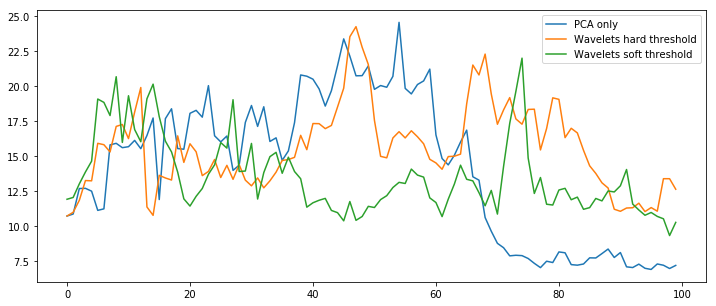

In [102]:
plt.figure(figsize=(12, 5))

#plt.plot(results["mean_no_wv_stacked.fits"][0:100])
plt.plot(results["mean_no_wv.fits"][0:100], label="PCA only")
plt.plot(np.asarray(results["mean_hard_wv.fits"][0:100]), label="Wavelets hard threshold")
plt.plot(results["mean_soft_wv.fits"][0:100], label="Wavelets soft threshold")
plt.legend()

In [103]:
print np.argmax(results["mean_no_wv.fits"][0:100])
print np.argmax(results["mean_hard_wv.fits"][0:100])
print np.argmax(results["mean_soft_wv.fits"][0:100])

54
47
74


In [104]:
print np.max(results["mean_no_wv.fits"][0:100])
print np.max(np.asarray(results["mean_hard_wv.fits"][0:100]))
print np.max(results["mean_soft_wv.fits"][0:100])

24.5347893311
24.2283592116
21.9837642422
